In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1z1G-T13kUEEKmAJyWL2BN6ecPsEZmGJ0' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Copy of 190115 DW för Routings och forecast.xlsx')  

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import datetime
from matplotlib import pyplot as plt

from IPython.display import display

In [0]:
df = pd.read_excel('Copy of 190115 DW för Routings och forecast.xlsx')
lot = pd.read_excel('Copy of 190115 DW för Routings och forecast.xlsx', sheet_name=1)

lot['orders'] = lot['FORECAST_YEAR']/(lot['FIXED_LOT_SIZE']+lot['MIN_LOT_SIZE'])

In [0]:
joined = df.merge(lot, on='MATNR', how='right')
joined = joined[(joined.OPERATION_TIME!=0)][(joined.FORECAST_YEAR!=0)]
joined.dropna(subset=['OPERATION_TIME'], inplace=True)

In [0]:
joined.tail()

,MATNR,OP_NR,OPERATION_TIME,OPERATION_UNIT,SETUP_TIME,SETUP_UNIT,FCREATED,WORK_CENTER,WORK_CENTER_TXT,FIXED_LOT_SIZE,MIN_LOT_SIZE,LOT_SIZE,FORECAST_YEAR,orders
26972,8940164637,135.0,0.5,MIN,10.0,MIN,2019-01-29,55683691,VIBRATIONSTRUMLING,73,0,FX,146.0,2.000000
27027,94963,10.0,5.5,MIN,150.0,MIN,2019-01-29,55235206,TRAUB TNX (PLANETARY SHAFT),11,0,FX,9.0,0.818182
27028,94963,20.0,0.3,MIN,10.0,MIN,2019-01-29,55764290,IBSEN 1.2,11,0,FX,9.0,0.818182
27029,94963,40.0,1.2,MIN,120.0,MIN,2019-01-29,55372398,STUDER S31,11,0,FX,9.0,0.818182
27030,94963,50.0,0.3,MIN,10.0,MIN,2019-01-29,55680892,ALLKA JET,11,0,FX,9.0,0.818182


In [0]:
joined['orders_round'] = joined['orders'].apply(lambda x:math.ceil(x) if (~np.isnan(x)) and (~np.isinf(x)) else 1)
joined['total_time_per_order'] = joined['SETUP_TIME'] + joined['OPERATION_TIME']*joined['FIXED_LOT_SIZE']
joined['total_time'] = joined['total_time_per_order']*joined['orders_round']

In [0]:
# Number of work station
len(joined.WORK_CENTER.unique())

93

In [0]:
# ALL unique materials
all_materials = list(set(joined.MATNR.values))

In [0]:
# Prepare the material list

#input_list = all_materials
input_lst = ['4210217100', '4216266700', '4216289500', '4216292900', '4220029800']
#lst_2 = ['4210195000', '4210386000', '4210215100', '4210194500', '4210440901', '6155211140', '6155830730', '4110061500', '6154752860']

In [0]:
def select_mat(df, input_lst):
  df = df[df.MATNR.isin(input_lst)]
  print (df.shape)
  return df

In [0]:
sl_df = select_mat(joined, input_lst)

(39, 17)


In [0]:
def get_jobs(df, input_lst):
    jobs = {}
    for mat in input_lst:
        filtered = df[df.MATNR==mat][['OP_NR', 'WORK_CENTER', 'total_time_per_order']]
        machines = list(zip(filtered.WORK_CENTER, filtered.total_time_per_order))
        tasks = dict(zip(filtered.OP_NR, machines))
        jobs[mat] = tasks
    return jobs

In [0]:
jobs = get_jobs(sl_df, input_lst)

In [0]:
jobs

{'4210194500': {10.0: ('55235296', 3062.0), 130.0: ('55683691', 148.6)},
 '4210195000': {20.0: ('55235296', 5203.360000000001),
  85.0: ('55683591', 237.10000000000002)},
 '4210215100': {10.0: ('55235296', 3568.5), 20.0: ('55683691', 300.0)},
 '4210386000': {10.0: ('56235203', 3600.9500000000003),
  20.0: ('55764290', 315.40000000000003),
  30.0: ('56235159', 2291.19),
  35.0: ('55680892', 157.70000000000002),
  45.0: ('55681052', 161.913)},
 '4210440901': {10.0: ('56235203', 2035.9),
  20.0: ('55764290', 297.0),
  30.0: ('56235159', 3042.35),
  33.0: ('55680892', 148.5)}}

In [0]:
# Set priority queue
class PriorityQueue(object): 
    def __init__(self): 
        self.queue = [] 
  
    def __str__(self): 
        return ' '.join([str(i) for i in self.queue]) 
    def __len__(self):
        return len(self.queue)
  
    # for checking if the queue is empty 
    def is_empty(self): 
        return len(self.queue) == 0 
  
    # for inserting an element in the queue 
    def insert(self, data): 
        self.queue.append(data)
        
    def extend(self, list):
      self.queue.extend(list)
  
    # for popping an element based on Priority 
    def delete(self): 
        try: 
            min = 0
            for i in range(len(self.queue)): 
                if self.queue[i] > self.queue[min]:
                    min = i 
            item = self.queue[min] 
            del self.queue[min] 
            return item 
        except IndexError: 
            print() 
            exit() 

In [0]:
class Job(object): 
    def __init__(self, material, tasks):
      self.material = material
      self.current = 0;
      self.tasks = tasks
      
    def __str__(self):
      return self.material + " " + str(self.current) + " " + str(self.tasks)
      
    def __lt__(self, job2):
      return self.tasks[self.current]['time'] < job2.tasks[job2.current]['time']
    
    def __gt__(self, job2):
      return self.tasks[self.current]['time'] > job2.tasks[job2.current]['time']

In [0]:
# Input orders data for each material
material_orders = {'4210217100':1, '4216266700':1, '4216289500':1, '4216292900':1, '4220029800':1
#      '4210195000':2,
#      '4210386000':1,
#      '4210215100':1,
#      '4210194500':3,
#      '4210440901':1 
}
#dict(zip(all_materials, np.ones(len(all_materials))))

unfinished_jobs = PriorityQueue()

# Reshape data into a more workable structure
for material, operations in jobs.items():
  order_size = int(material_orders[material])
  
  for i in range(order_size):
    tasks = []
    for op_nr, v in operations.items():
      tasks.append({
          'op_nr': op_nr,
          'machine': v[0],
          'time': v[1]
      })

    job = Job(material, tasks)
    unfinished_jobs.insert(job)

  
finished_jobs = []
in_progress_jobs = {}
time = 0
num_jobs = len(unfinished_jobs)

while len(finished_jobs) < num_jobs:
  tmp = []
  
  # Try to place tasks from jobs on available machines
  while(unfinished_jobs.is_empty() == False):
      job = unfinished_jobs.delete()
      current_task = job.tasks[job.current]
      machine_id = current_task['machine']
      
      # Machine is available, let it work on job task
      if machine_id not in in_progress_jobs:
          in_progress_jobs[machine_id] = {
              't_start': time,
              't_end': time + current_task['time'],
              'job': job
          }
      # Machine required for task is unavailable, try again later
      else:
          tmp.append(job)
 # Put back jobs that we could not place on any machine
  unfinished_jobs.extend(tmp)  
 
 # Find the inprogress job with the least time to finish task
  t_smallest = np.inf
  j_in_progress_smallest = None
  j_smallest_machine = None
  
  for machine_id, in_progress_job in in_progress_jobs.items():
      end_time = in_progress_job['t_end']
      if end_time < t_smallest:
          t_smallest = end_time
          j_in_progress_smallest = in_progress_job
          j_smallest_machine = machine_id;

  # Task is done remove it from in progress
  del in_progress_jobs[j_smallest_machine]
  
  # Save start & end times
  # Actual job object
  j_smallest_job = j_in_progress_smallest['job']
  
  # Save start and end times on task dict
  t_start = j_in_progress_smallest['t_start']
  t_end = j_in_progress_smallest['t_end']
  j_smallest_job.tasks[j_smallest_job.current]['t_start'] = t_start
  j_smallest_job.tasks[j_smallest_job.current]['t_end'] = t_end
  
  # Move on to next task
  j_smallest_job.current += 1
  
  # Check if any remaining tasks
  if j_smallest_job.current < len(j_smallest_job.tasks):
    unfinished_jobs.insert(j_smallest_job)
  else:
    finished_jobs.append(j_smallest_job)
    
  # Move time forward to the time when task finished
  time = t_smallest

In [0]:
def make_schedule(finished_jobs):
  schedule = {'mat_nr':[], 'work_center':[], 'start_time':[], 'end_time':[]}

  for j in finished_jobs:
    for task in j.tasks:
      schedule['mat_nr'].append(j.material)
      schedule['work_center'].append(task['machine'])
      schedule['start_time'].append(task['t_start'])
      schedule['end_time'].append(task['t_end'])
  schedule=pd.DataFrame(schedule, columns=['mat_nr', 'work_center', 'start_time', 'end_time'])
  return schedule

In [0]:
schedule = make_schedule(finished_jobs)

In [0]:
schedule.to_csv('schedule_with_vlad_mat.csv')

In [0]:
def to_t_delt(number):
    return pd.to_timedelta(f'{math.floor(number)}hours {(number - math.floor(number)) * 60}min')

In [0]:
# Transform the timedeltas to timestamps
from datetime import datetime
schedule['start_time_dt'] = schedule['start_time'].apply(lambda x: to_t_delt(x/60)+datetime(2019,1,1))
schedule['end_time_dt'] = schedule['end_time'].apply(lambda x: to_t_delt(x/60)+datetime(2019,1,1))

In [0]:
schedule

,mat_nr,work_center,start_time,end_time,start_time_dt,end_time_dt
0,4216292900,56235203,0.00,221.50,2019-01-01 00:00:00.000,2019-01-01 03:41:30.000
1,4216292900,55247053,221.50,341.00,2019-01-01 03:41:30.000,2019-01-01 05:41:00.000
2,4216292900,55246551,341.00,548.50,2019-01-01 05:41:00.000,2019-01-01 09:08:30.000
3,4216292900,55500500,548.50,583.50,2019-01-01 09:08:30.000,2019-01-01 09:43:30.000
4,4216292900,55680892,583.50,598.50,2019-01-01 09:43:30.000,2019-01-01 09:58:30.000
5,4216292900,55764290,598.50,638.50,2019-01-01 09:58:30.000,2019-01-01 10:38:30.000
6,4216292900,55372398,638.50,748.50,2019-01-01 10:38:30.000,2019-01-01 12:28:30.000
7,4216292900,55680892,748.50,763.50,2019-01-01 12:28:30.000,2019-01-01 12:43:30.000
8,4216292900,55135280,763.50,890.15,2019-01-01 12:43:30.000,2019-01-01 14:50:09.000
9,4220029800,55235206,0.00,330.40,2019-01-01 00:00:00.000,2019-01-01 05:30:24.000


In [0]:
def plot_schedule(df, input_lst):
  work_centers = list(set(df.work_center))
  y_pos = np.arange(len(set(df.work_center)))
  colors = dict(zip(input_lst, ['red', 'green', 'yellow', 'black', 'blue', 'cyan', 'magenta', '0.75', '0.5']))

  fig, ax = plt.subplots(figsize=(15,5))

  for i in range(len(work_centers)):

      j=0
      for index, row in df[df.work_center==work_centers[i]].iterrows():
          mat = row.mat_nr
          t_start = row.start_time
          t_end = row.end_time
          ax.barh(y_pos[i], t_end-t_start, left=t_start, height=0.5, color=colors[mat])  
          j+=1

  #ax.set_yticklabels(work_centers)
  ax.set_ylabel('Work_center')
  ax.set_xlabel('Time (Min)')
  ax.autoscale()
 # ax.legend(input_lst)
  plt.show()

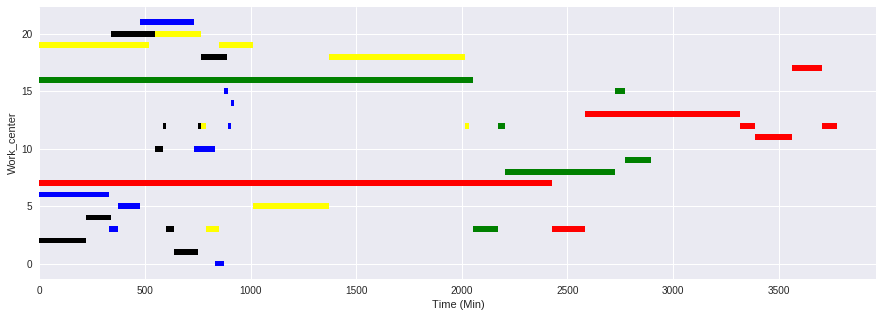

In [0]:
plot_schedule(schedule, input_lst)

**`Making` a network graph**

In [0]:
joined.head()

,MATNR,OP_NR,OPERATION_TIME,OPERATION_UNIT,SETUP_TIME,SETUP_UNIT,FCREATED,WORK_CENTER,WORK_CENTER_TXT,FIXED_LOT_SIZE,MIN_LOT_SIZE,LOT_SIZE,FORECAST_YEAR,orders,orders_round,total_time_per_order,total_time
16,1033,10.0,5.85,MIN,60.0,MIN,2019-01-29,55235206,TRAUB TNX (PLANETARY SHAFT),10,0,FX,4.0,0.4,1,118.5,118.5
17,1033,15.0,2.00,MIN,20.0,MIN,2019-01-29,55500500,BÄNKGRADNING,10,0,FX,4.0,0.4,1,40.0,40.0
18,1033,17.0,0.10,MIN,10.0,MIN,2019-01-29,55680892,ALLKA JET,10,0,FX,4.0,0.4,1,11.0,11.0
19,1033,20.0,0.33,MIN,10.0,MIN,2019-01-29,55764290,IBSEN 1.2,10,0,FX,4.0,0.4,1,13.3,13.3
20,1033,30.0,2.00,MIN,89.0,MIN,2019-01-29,55372396,STUDER S31,10,0,FX,4.0,0.4,1,109.0,109.0


In [0]:
df = joined[['MATNR', 'OP_NR', 'WORK_CENTER', 'total_time_per_order']].dropna()

In [0]:
# Construct the "to_work_center" column by shift the work_center column
df['to_work_center'] = df.groupby(['MATNR'])['WORK_CENTER'].shift(-1)

In [0]:
df_gr = df.groupby(['WORK_CENTER', 'to_work_center']).count()['MATNR']
df_gr = df_gr.reset_index().dropna()

In [0]:
df_gr.head(10)

,WORK_CENTER,to_work_center,MATNR
0,51402620,55372391,1
1,54001000,55764260,1
2,54001000,56147052,1
3,550,55500500,1
4,550,556,4
5,550,55680892,1
6,550,557,1
7,550,56147052,1
8,55035205,55247053,7
9,55035205,55371254,1


In [0]:
df_filtered = df_gr[df_gr.MATNR>5]

In [0]:
df_filtered.head()

,WORK_CENTER,to_work_center,MATNR
8,55035205,55247053,7
12,55035205,55373261,6
14,55035205,55400500,6
17,55035205,55680892,13
18,55035205,55683691,11


In [0]:
# Get the from_to matrix
from_to = pd.pivot_table(
               df[['MATNR', 'WORK_CENTER', 'to_work_center']], 
               values=['MATNR'], 
               index = ['WORK_CENTER'], 
               columns=['to_work_center'],
               aggfunc=lambda x: len(x.unique())
                        )
print (from_to.shape)
from_to.head(10)

(123, 106)


MATNR                                                        \
to_work_center 51402620 55035208 55135162 55135165 55135191 55135210 55135280   
WORK_CENTER                                                                     
51402620            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
54001000            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
550                 NaN      NaN      NaN      NaN      NaN      NaN      NaN   
55035205            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
55035208            NaN      1.0      NaN      NaN      NaN      NaN      NaN   
55135160            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
55135161            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
55135162            NaN      NaN      NaN      3.0      NaN      NaN      NaN   
55135163            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
55135164            NaN      NaN      NaN      NaN      NaN      NaN      NaN   

                                            ...                                \
to_work_center 55175601 55180865 55180866   ...    OLD35275 OLD35282 OLD35286   
WORK_CENTER                                 ...                                 
51402620            NaN      NaN      NaN   ...         NaN      NaN      NaN   
54001000            NaN      NaN      NaN   ...         NaN      NaN      NaN   
550                 NaN      NaN      NaN   ...         NaN      NaN      NaN   
55035205            NaN      NaN      NaN   ...         NaN      NaN      NaN   
55035208            NaN      NaN      NaN   ...         NaN      NaN      NaN   
55135160            NaN      NaN      2.0   ...         NaN      NaN      NaN   
55135161            NaN      NaN      NaN   ...         NaN      NaN      NaN   
55135162           39.0      NaN      2.0   ...         NaN      NaN      NaN   
55135163            NaN      NaN      1.0   ...         NaN      NaN      NaN   
55135164            2.0      NaN     16.0   ...         NaN      NaN      NaN   

                                                                               
to_work_center OLD35287 OLD35288 OLD35291 OLD35350 OLD41153 OLD44052 OLD70891  
WORK_CENTER                                                                    
51402620            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
54001000            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
550                 NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55035205            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55035208            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55135160            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55135161            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55135162            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55135163            NaN      NaN      NaN      NaN      NaN      NaN      NaN  
55135164            NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[10 rows x 106 columns]

In [0]:
import networkx as nx

def plot_network(df):
  G = nx.from_pandas_edgelist(df, 'WORK_CENTER', 'to_work_center')
  DiG = nx.DiGraph(G)
  
  fig,ax=plt.subplots(figsize=(20,20))
  # Plot it
  nx.draw(DiG, with_labels=True, font_color='black', edge_color='green', arrows=True)
  plt.show()
  
  
def plot_network_weight(df):
  G = nx.from_pandas_edgelist(df, 'WORK_CENTER', 'to_work_center', 'MATNR')
  DiG = nx.DiGraph(G)
  
  fig,ax=plt.subplots(figsize=(30,30))
  # Plot it
  nx.draw(DiG, with_labels=True, font_color='black', edge_color='green', arrows=True)
  plt.show()

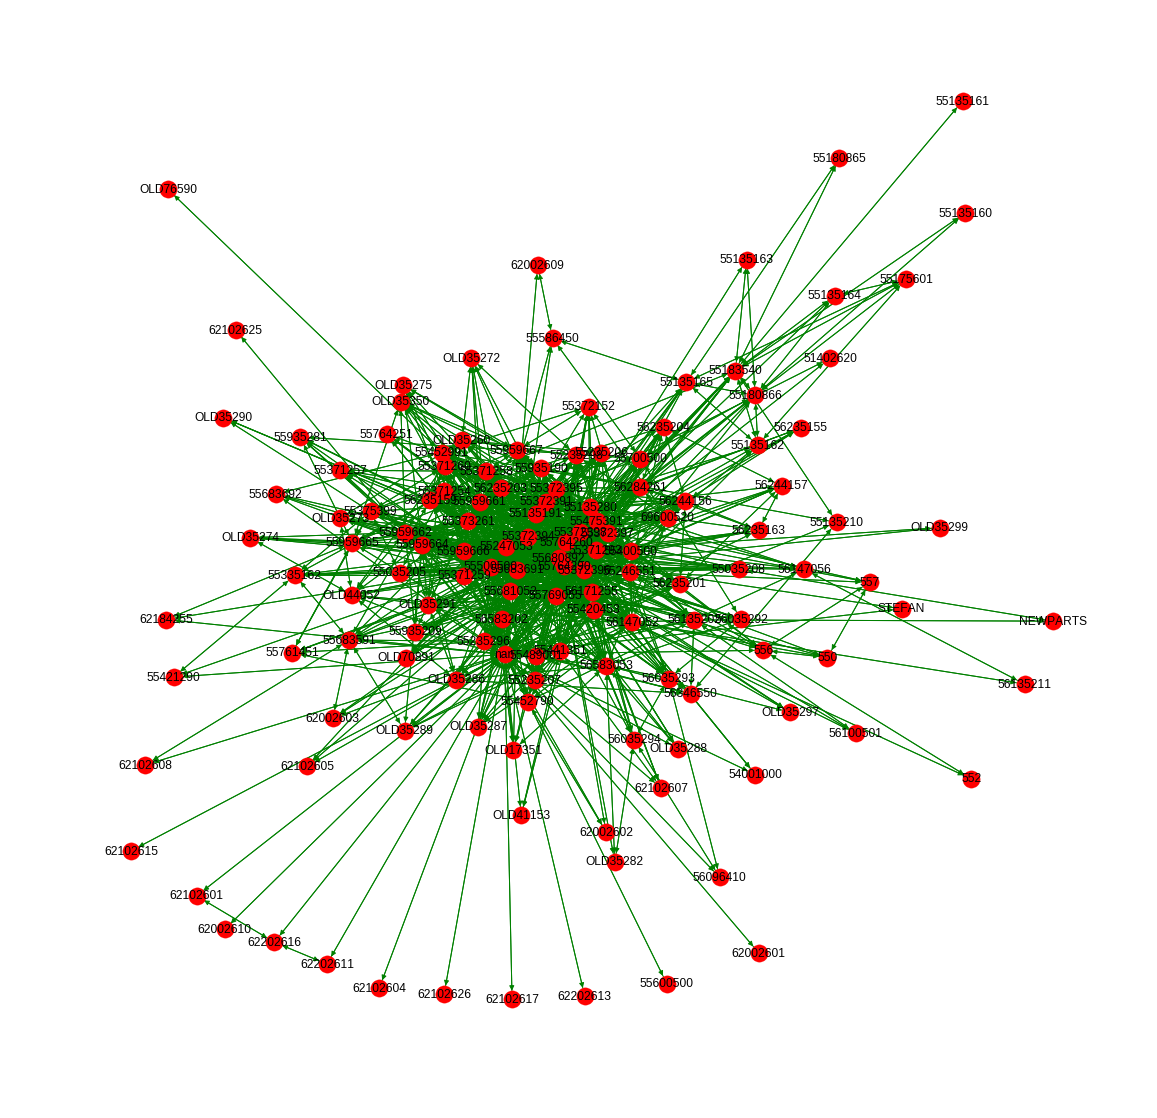

In [0]:
plot_network(df)

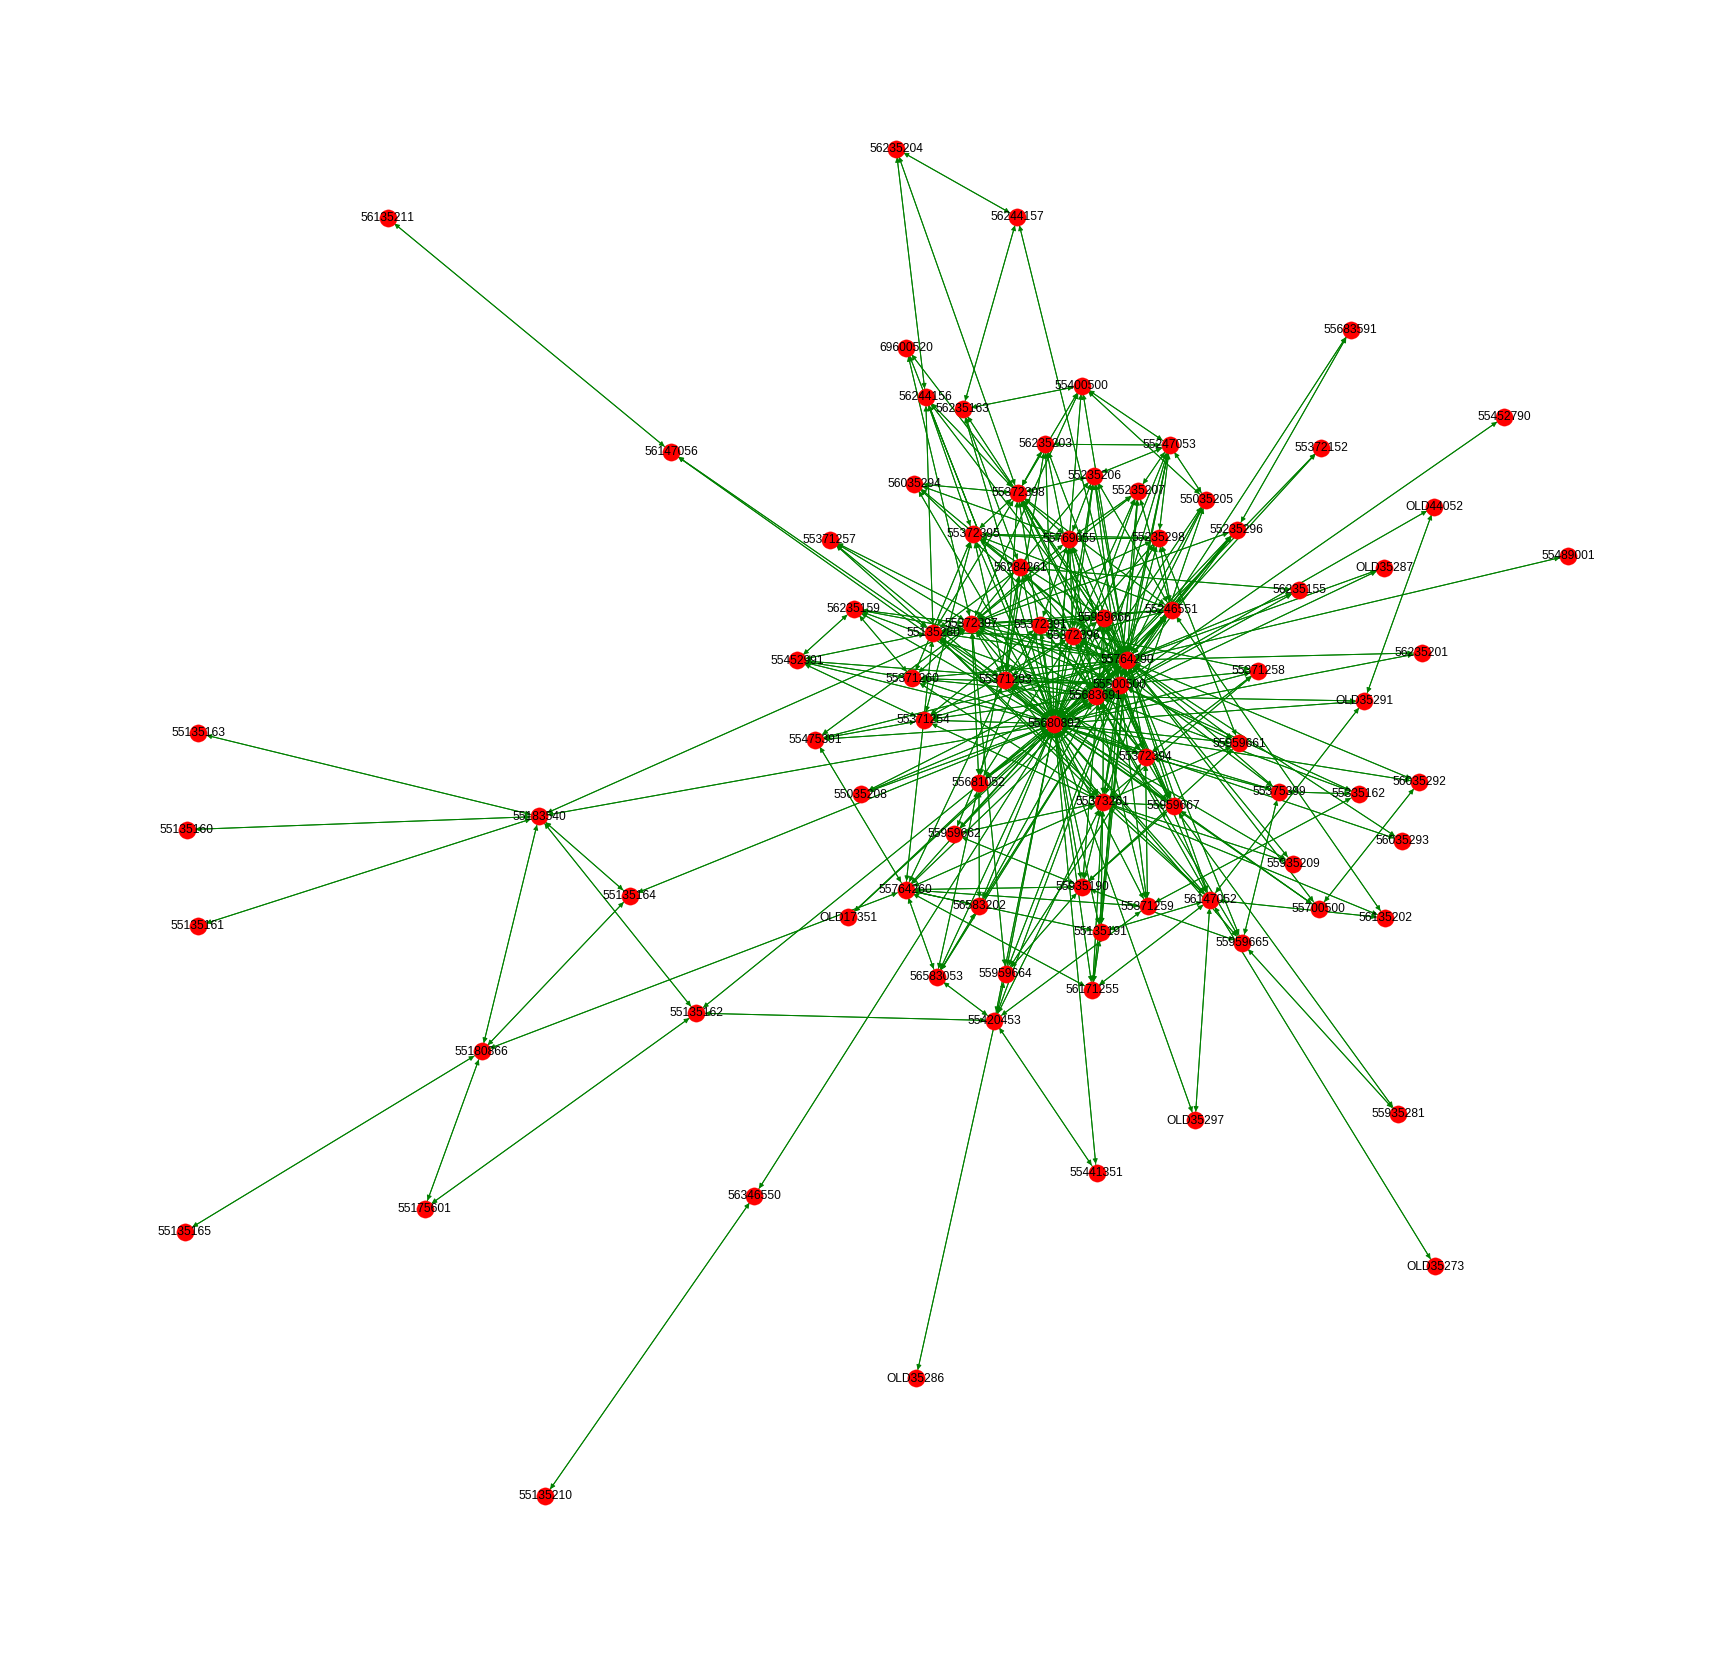

In [0]:
plot_network_weight(df_filtered[~df_filtered.WORK_CENTER.isin(['OLD35350', '557', '556'])])